In [97]:
import numpy as np, math
import matplotlib.pyplot as plt
import pandas as pd

import yfinance as yf
from scipy import stats
from scipy.stats import norm
import pandas_datareader as pdr

In [98]:
#Asset list
lst=['AAPL','WMT','ADM','GM','HD','JNJ']

#dates for model calibration
start_data='2018-01-01'
end_data='2019-01-01'

## Volatility estimate for list of stocks in 2018

In [103]:
sigma=[]
for i in range(0,len(lst)):
    stock = pdr.get_data_yahoo(lst[i],start = start_data,end=end_data)['Adj Close']
    dlogstock = np.diff(np.log(stock))
    dlogstock.mean()
    M = dlogstock.size
    Δt = T/M
    dlogstock.mean()/Δt

    σbar = dlogstock.std()/math.sqrt(Δt)
    sigma.append(σbar)

In [104]:
#performance metrics
vol_df = pd.DataFrame(index=['Vol'], columns=['AAPL', 'WMT', 'ADM', 'GM', 'HD','JNJ'])
vol_df.loc['Vol'] = sigma
vol_df

,AAPL,WMT,ADM,GM,HD,JNJ
Vol,0.286035,0.239924,0.187269,0.314638,0.225919,0.221443


## Pricing euro call using MC
## Comparison with Black-Scholes pricing (that I implemented previously)
## Graph of how fast the MC price will converge with Black-Scholes price per number of MC simulations

In [105]:
# Data 1 year maturity call
T = 1 # five years
M = T*252
Δt = T/M
S0 = 100
r = 0.05
σ = 0.20
K = 105

N = 1000000 # number of simulations
rng = np.random.default_rng(seed=12345)

In [106]:
def f1(N_M_Δt_S0_r_σ):
    N,M,Δt,S0,r,σ = N_M_Δt_S0_r_σ
    S = np.empty((N,M+1))
    S[:,0] = S0
    S[:,1:] = np.exp((r-σ**2/2)*Δt + σ*math.sqrt(Δt)*rng.standard_normal(size=(N,M)))
    return S.cumprod(axis=1)

In [107]:
sims = f1((N,M,Δt,S0,r,σ))
Sfinal = sims[:,-1]
values = np.maximum(Sfinal - K,0)

In [108]:
eurocallvalue = values.mean()*math.exp(-r*T)
eurocallvalue

8.018005146541974

In [109]:
def ask_for_input():
    T = float(input('Please enter time to maturity:'))
    r = float(input('Please enter a rate:'))
    d = float(input('Please enter dividend rate:'))
    K = float(input('Please enter strike:'))
    S = float(input('Please enter spot price:'))
    sigma = float(input('Please enter volatility:'))
    return T, r, d, K, S, sigma



In [110]:
#compare with Black Scholes pricing model
def get_call():
    T, r, d, K, S, sigma = ask_for_input()
    if K==0 or T==0 or sigma ==0:
        print('Not a valid input')
    elif d == 0:
        d1 = (np.log(S/K)+(r+0.5*sigma**2)*T) / (sigma*np.sqrt(T))
        d2 = d1-sigma*np.sqrt(T)

        call = S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
        print(call)
        return call
    elif d < 0:
        print('Not a valid dividend input')
    else:
        d1 = (np.log(S/K)+(r+0.5*sigma**2)*T) / (sigma*np.sqrt(T))
        d2 = d1-sigma*np.sqrt(T)

        call = np.exp(-d*T)*S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    return(call)
bs_call=get_call()

Please enter time to maturity: 1
Please enter a rate: 0.05
Please enter dividend rate: 0
Please enter strike: 105
Please enter spot price: 100
Please enter volatility: 0.2


8.021352235143176


In [111]:
#let's take a look how fast monte carlo converges with blackscholes depending on number of simulations
num_sims=np.arange(1,10000,10)
mc_call=[]
for i in range(len(num_sims)):
    N=num_sims[i]
    sims = f1((N,M,Δt,S0,r,σ))
    Sfinal = sims[:,-1]
    values = np.maximum(Sfinal - K,0)
    eurocallvalue = values.mean()*math.exp(-r*T)
    mc_call.append(eurocallvalue)
    

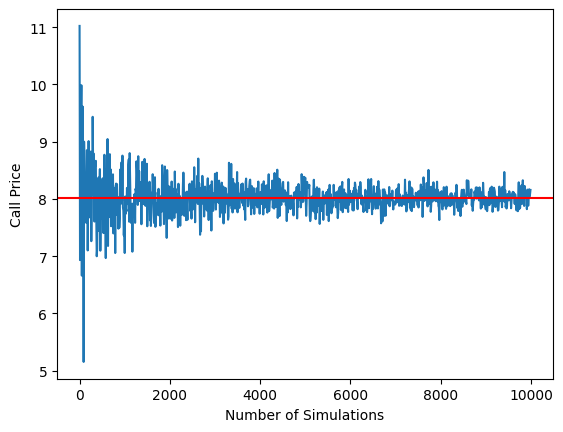

In [112]:
plt.plot(num_sims,mc_call)
plt.xlabel('Number of Simulations')
plt.ylabel('Call Price')
plt.axhline(y = bs_call, color = 'r', linestyle = '-')

## As we can see, monte carlo simulation will converge to the Black Scholes price of the option as the number of simulations increases